In [13]:
# Required packages:
# pip install networkx numpy pandas matplotlib scikit-learn seaborn pyvis python-louvain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.ensemble import IsolationForest
import seaborn as sns
from pyvis.network import Network
import community.community_louvain as community_louvain
from collections import Counter
import os
import logging

# Set up logging
logging.basicConfig(
    filename=os.path.join(output_path, 'analysis.log'),
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Set up the base path
base_path = os.path.join(os.path.expanduser('~'), 'Desktop', 'Network Analysis Tool')

# Ensure the path exists
if not os.path.exists(base_path):
    raise FileNotFoundError(f"Directory not found: {base_path}")

# Load the nodes and edges data with proper path handling
try:
    nodes_df = pd.read_csv(os.path.join(base_path, 'ICS_OT Nodes.csv'))
    edges_df = pd.read_csv(os.path.join(base_path, 'ICS_OT Edges.csv'))
except FileNotFoundError as e:
    raise FileNotFoundError(f"Error loading CSV files: {e}")

# Create output directory if it doesn't exist
output_path = os.path.join(base_path, 'output')
os.makedirs(output_path, exist_ok=True)

# Create an undirected graph
G = nx.Graph()

# Add nodes with labels and types of devices
for index, row in nodes_df.iterrows():
    G.add_node(row['Id'], label=row['Label'], shape=row.get('Shape', 'ellipse'))

# Add edges to represent connections
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'])

# Basic network metrics
print("\nNetwork Summary Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.3f}")

# Check if the graph is a tree or forest
is_tree = nx.is_tree(G)
is_forest = nx.is_forest(G)
print(f"Is tree: {is_tree}")
print(f"Is forest: {is_forest}")

# Find root nodes (nodes with degree 1)
root_nodes = [node for node, degree in dict(G.degree()).items() if degree == 1]
print(f"Number of endpoint nodes: {len(root_nodes)}")

def analyze_network_structure(G):
    """Analyze the network structure and print relevant metrics"""
    print("\nDetailed Network Analysis:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Network density: {nx.density(G):.3f}")
    
    # Connectivity analysis
    components = list(nx.connected_components(G))
    print(f"Number of connected components: {len(components)}")
    for i, comp in enumerate(components, 1):
        print(f"Component {i} size: {len(comp)} nodes")
    
    # Cycle analysis
    cycles = list(nx.cycle_basis(G))
    print(f"Number of cycles: {len(cycles)}")
    if cycles:
        print("Cycle lengths:", [len(cycle) for cycle in cycles])
    
    # Endpoint analysis
    endpoints = [node for node, degree in dict(G.degree()).items() if degree == 1]
    print(f"Number of endpoints: {len(endpoints)}")
    
    # Central nodes
    degree_cent = nx.degree_centrality(G)
    highest_degree = max(degree_cent.items(), key=lambda x: x[1])
    print(f"Most central node by degree: {highest_degree[0]} "
          f"(centrality: {highest_degree[1]:.3f})")
    
    return components, cycles, endpoints

# Run the structure analysis
components, cycles, endpoints = analyze_network_structure(G)

def visualize_with_cycle(G, title, save_path=None):
    """Draw the network with the cycle highlighted"""
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Use spring layout with higher k value for better spacing
    pos = nx.spring_layout(G, k=2/np.sqrt(G.number_of_nodes()), iterations=50)
    
    # Get the cycle
    cycles = list(nx.cycle_basis(G))
    cycle_edges = []
    if cycles:
        cycle = cycles[0]  # We know there's exactly one cycle
        # Create pairs of nodes that form the cycle
        cycle_edges = list(zip(cycle, cycle[1:] + [cycle[0]]))
    
    # Draw non-cycle edges
    all_edges = set(G.edges())
    non_cycle_edges = all_edges - set(cycle_edges)
    nx.draw_networkx_edges(G, pos,
                          edgelist=non_cycle_edges,
                          edge_color='gray',
                          alpha=0.5,
                          ax=ax)
    
    # Draw cycle edges in red
    if cycle_edges:
        nx.draw_networkx_edges(G, pos,
                             edgelist=cycle_edges,
                             edge_color='red',
                             width=2,
                             ax=ax)
    
    # Calculate node colors based on criticality
    degree_cent = nx.degree_centrality(G)
    between_cent = nx.betweenness_centrality(G)
    node_colors = [(degree_cent[node] + between_cent[node])/2 for node in G.nodes()]
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_size=[3000 * (1 + G.degree(node)) for node in G.nodes()],
                                 node_color=node_colors,
                                 cmap=plt.cm.viridis,
                                 ax=ax)
    
    # Add labels
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                              norm=plt.Normalize(vmin=min(node_colors),
                                               vmax=max(node_colors)))
    sm.set_array([])
    plt.colorbar(sm, label='Centrality Score', ax=ax)
    
    # Set title and remove axes
    ax.set_title(f"{title}\nRed edges indicate the cycle")
    ax.set_axis_off()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

# Calculate path lengths
path_lengths = dict(nx.all_pairs_shortest_path_length(G))
max_path_length = max(max(lengths.values()) for lengths in path_lengths.values())
print(f"\nMaximum path length (network diameter): {max_path_length}")

# Calculate node criticality
def calculate_node_criticality(G):
    """Calculate how critical each node is based on network segmentation"""
    criticality = {}
    original_components = nx.number_connected_components(G)
    
    for node in G.nodes():
        # Create a copy of the graph without the current node
        G_temp = G.copy()
        G_temp.remove_node(node)
        
        # Calculate the increase in number of components
        new_components = nx.number_connected_components(G_temp)
        criticality[node] = new_components - original_components
        
    return criticality

# Calculate criticality scores
criticality_scores = calculate_node_criticality(G)
print("\nTop 5 critical nodes (based on network segmentation):")
sorted_criticality = dict(sorted(criticality_scores.items(), 
                               key=lambda x: x[1], reverse=True)[:5])
for node, score in sorted_criticality.items():
    node_label = G.nodes[node].get('label', node)
    print(f"Node {node} ({node_label}): splits network into {score + 1} components")

# Calculate centrality measures
centrality_measures = {
    'Degree_Centrality': nx.degree_centrality(G),
    'Betweenness_Centrality': nx.betweenness_centrality(G),
    'Closeness_Centrality': nx.closeness_centrality(G),
    'Eigenvector_Centrality': nx.eigenvector_centrality(G, max_iter=1000)
}

centrality_df = pd.DataFrame(centrality_measures).sort_index()

# Anomaly detection
def detect_anomalies(df):
    """Detect anomalies in centrality measures"""
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    df['anomaly'] = iso_forest.fit_predict(df)
    
    # Calculate anomaly scores
    anomaly_scores = iso_forest.score_samples(df.drop('anomaly', axis=1))
    df['anomaly_score'] = anomaly_scores
    
    return df

# Run anomaly detection
anomalies = detect_anomalies(centrality_df)
print("\nDetected Anomalies in Centrality Measures (ordered by anomaly score):")
anomalous_nodes = anomalies[anomalies['anomaly'] == -1].sort_values('anomaly_score')
for idx, row in anomalous_nodes.iterrows():
    node_label = G.nodes[idx].get('label', idx)
    print(f"Node {idx} ({node_label}):")
    print(f"  Anomaly score: {row['anomaly_score']:.3f}")
    print(f"  Degree centrality: {row['Degree_Centrality']:.3f}")
    print(f"  Betweenness centrality: {row['Betweenness_Centrality']:.3f}")

def visualize_network(G, criticality_scores, output_path):
    """Create interactive visualization"""
    net = Network(height='750px', width='100%', bgcolor='#ffffff',
                 font_color='#000000', notebook=False)
    
    # Get the cycle for highlighting
    cycles = list(nx.cycle_basis(G))
    cycle_nodes = set(cycles[0]) if cycles else set()
    
    # Add nodes
    for node in G.nodes():
        label = G.nodes[node]['label']
        is_cycle = 'Yes' if node in cycle_nodes else 'No'
        degree = G.degree(node)
        
        net.add_node(node,
                    label=label,
                    title=f"Node: {label}\n"
                          f"Criticality Score: {criticality_scores[node]}\n"
                          f"Degree: {degree}\n"
                          f"Part of Cycle: {is_cycle}",
                    size=25 * (1 + criticality_scores[node]),
                    color='red' if node in cycle_nodes else '#97c2fc')
    
    # Add edges
    for edge in G.edges():
        # Check if edge is part of the cycle
        is_cycle_edge = False
        if cycles:
            cycle = cycles[0]
            if (edge[0] in cycle and edge[1] in cycle and
                (abs(cycle.index(edge[0]) - cycle.index(edge[1])) == 1 or
                 abs(cycle.index(edge[0]) - cycle.index(edge[1])) == len(cycle) - 1)):
                is_cycle_edge = True
        
        net.add_edge(edge[0], edge[1],
                    color='red' if is_cycle_edge else 'gray')
    
    # Configure physics
    net.set_options("""
    {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -50,
          "centralGravity": 0.01,
          "springLength": 100,
          "springConstant": 0.08
        },
        "solver": "forceAtlas2Based",
        "stabilization": {"iterations": 150}
      }
    }
    """)
    
    # Save visualization
    output_file = os.path.join(output_path, 'network_visualization.html')
    try:
        net.save_graph(output_file)
    except Exception as e:
        print(f"Warning: Could not save interactive visualization: {str(e)}")

# Create visualizations
visualize_with_cycle(G, "Network Structure with Cycle Highlighted",
                    os.path.join(output_path, 'network_structure_with_cycle.png'))

# Create interactive visualization
try:
    visualize_network(G, criticality_scores, output_path)
except Exception as e:
    print(f"Warning: Could not create interactive visualization: {str(e)}")

# Create analysis report
with open(os.path.join(output_path, 'network_analysis_report.txt'), 'w') as f:
    f.write("Network Analysis Report\n")
    f.write("=====================\n\n")
    
    # Basic structure
    f.write("Network Structure:\n")
    f.write(f"- Nodes: {G.number_of_nodes()}\n")
    f.write(f"- Edges: {G.number_of_edges()}\n")
    f.write(f"- Network diameter: {max_path_length}\n")
    f.write(f"- Density: {nx.density(G):.3f}\n\n")
    
    # Cycle information
    cycles = list(nx.cycle_basis(G))
    f.write("Cycle Analysis:\n")
    if cycles:
        cycle = cycles[0]
        cycle_nodes = [G.nodes[n]['label'] for n in cycle]
        f.write(f"- One cycle found with {len(cycle)} nodes:\n")
        f.write(f"- Cycle path: {' -> '.join(cycle_nodes)}\n\n")
    
    # Critical nodes
    f.write("Critical Nodes:\n")
    for node, score in sorted_criticality.items():
        node_label = G.nodes[node].get('label', node)
        f.write(f"- {node_label}:\n")
        f.write(f"  * Splits network into {score + 1} components\n")
        f.write(f"  * Degree: {G.degree(node)}\n")
        if node in cycle_nodes:
            f.write("  * Part of the cycle\n")
    
    # Anomalous nodes
    f.write("\nAnomalous Nodes:\n")
    for idx, row in anomalous_nodes.iterrows():
        node_label = G.nodes[idx].get('label', node)
        f.write(f"- {node_label}:\n")
        f.write(f"  * Anomaly score: {row['anomaly_score']:.3f}\n")
        f.write(f"  * Degree centrality: {row['Degree_Centrality']:.3f}\n")
        f.write(f"  * Betweenness centrality: {row['Betweenness_Centrality']:.3f}\n")

# Calculate adjacency and Laplacian matrices
node_labels = list(G.nodes())
adjacency_matrix = nx.adjacency_matrix(G).todense()
laplacian_matrix = nx.laplacian_matrix(G).todense()

# Calculate eigenvalues of the Laplacian matrix
lap_eigenvalues, lap_eigenvectors = np.linalg.eigh(laplacian_matrix)

# Calculate spectral radius
spectral_radius = max(abs(lap_eigenvalues))

# Get Fiedler value and vector (second smallest eigenvalue and its eigenvector)
# Sort eigenvalues and get corresponding eigenvectors
idx = lap_eigenvalues.argsort()
fiedler_value = lap_eigenvalues[idx[1]]  # Second smallest eigenvalue
fiedler_vector = lap_eigenvectors[:, idx[1]]  # Corresponding eigenvector

print(f"\nSpectral Analysis:")
print(f"Spectral Radius: {spectral_radius:.3f}")
print(f"Fiedler Value: {fiedler_value:.3f}")
print("\nFiedler Vector Components (top 5 by magnitude):")
# Get the nodes with the largest magnitude Fiedler vector components
fiedler_components = list(zip(node_labels, fiedler_vector))
fiedler_components.sort(key=lambda x: abs(x[1]), reverse=True)
for node, value in fiedler_components[:5]:
    node_label = G.nodes[node]['label']
    print(f"Node {node} ({node_label}): {value:.3f}")

# Save centrality measures
centrality_df.to_csv(os.path.join(output_path, 'centrality_measures.csv'))

# Save vulnerability scores
vulnerability_df = pd.DataFrame.from_dict(criticality_scores, 
                                        orient='index', 
                                        columns=['Criticality Score'])
vulnerability_df.to_csv(os.path.join(output_path, 'vulnerability_scores.csv'))

# Save anomalies
anomalies.to_csv(os.path.join(output_path, 'anomalies.csv'))

print("\nAnalysis complete. Key findings:")
print("1. Network contains exactly one cycle of 5 nodes")
print("2. Switch 1 is the most critical node, splitting the network into 6 components")
print("3. Three nodes show anomalous behavior based on centrality measures")
print("4. The network has a relatively long diameter (10) for its size")
print("5. The network has 13 endpoint nodes, suggesting multiple branches")

print("\nOutput files saved in:", output_path)
print("- network_structure_with_cycle.png")
print("- network_visualization.html")
print("- network_analysis_report.txt")
print("- centrality_measures.csv")
print("- vulnerability_scores.csv")
print("- anomalies.csv")


Network Summary Statistics:
Number of nodes: 31
Number of edges: 31
Network density: 0.067
Is tree: False
Is forest: False
Number of endpoint nodes: 13

Detailed Network Analysis:
Number of nodes: 31
Number of edges: 31
Network density: 0.067
Number of connected components: 1
Component 1 size: 31 nodes
Number of cycles: 1
Cycle lengths: [5]
Number of endpoints: 13
Most central node by degree: 2 (centrality: 0.200)

Maximum path length (network diameter): 10

Top 5 critical nodes (based on network segmentation):
Node 2 (Switch 1): splits network into 6 components
Node 23 (PLC 4): splits network into 5 components
Node 5 (HMI 1): splits network into 4 components
Node 14 (PA Signal Line): splits network into 4 components
Node 9 (I/O 1): splits network into 3 components


C:\Users\Service Casket\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Detected Anomalies in Centrality Measures (ordered by anomaly score):
Node 2 (Switch 1):
  Anomaly score: -0.725
  Degree centrality: 0.200
  Betweenness centrality: 0.667
Node 5 (HMI 1):
  Anomaly score: -0.694
  Degree centrality: 0.133
  Betweenness centrality: 0.687
Node 23 (PLC 4):
  Anomaly score: -0.596
  Degree centrality: 0.167
  Betweenness centrality: 0.253

Spectral Analysis:
Spectral Radius: 7.272
Fiedler Value: 0.054

Fiedler Vector Components (top 5 by magnitude):
Node 15 (Device 1): 0.305
Node 16 (Device 2): 0.305
Node 17 (Device 3): 0.305
Node 14 (PA Signal Line): 0.288
Node 31 (Crown Jewel): -0.265

Analysis complete. Key findings:
1. Network contains exactly one cycle of 5 nodes
2. Switch 1 is the most critical node, splitting the network into 6 components
3. Three nodes show anomalous behavior based on centrality measures
4. The network has a relatively long diameter (10) for its size
5. The network has 13 endpoint nodes, suggesting multiple branches

Output files 

In [14]:
# Add after existing imports
from sklearn.preprocessing import StandardScaler
from itertools import combinations

def calculate_attack_surface(G):
    """Calculate attack surface metrics"""
    # Identify potential entry points (nodes with degree 1 or connected to external nodes)
    entry_points = [node for node in G.nodes() if G.degree(node) == 1]
    
    # Calculate shortest paths from entry points to critical assets
    critical_assets = ['Crown Jewel', 'SCADA Server', 'HMI 1', 'HMI 2', 'HMI 3']
    critical_node_ids = [node for node, attr in G.nodes(data=True) 
                        if attr['label'] in critical_assets]
    
    attack_paths = {}
    for entry in entry_points:
        entry_label = G.nodes[entry]['label']
        attack_paths[entry_label] = {}
        
        for target in critical_node_ids:
            target_label = G.nodes[target]['label']
            if nx.has_path(G, entry, target):
                path = nx.shortest_path(G, entry, target)
                attack_paths[entry_label][target_label] = len(path) - 1  # Number of hops
    
    return attack_paths

def analyze_network_resilience(G):
    """Analyze network resilience to targeted attacks"""
    original_connectivity = nx.node_connectivity(G)
    original_components = nx.number_connected_components(G)
    
    # Analyze impact of removing critical nodes in pairs
    critical_nodes = list(sorted_criticality.keys())[:3]  # Top 3 critical nodes
    critical_pairs = list(combinations(critical_nodes, 2))
    
    pair_impacts = {}
    for pair in critical_pairs:
        G_temp = G.copy()
        G_temp.remove_nodes_from(pair)
        
        new_components = nx.number_connected_components(G_temp)
        largest_component = max(nx.connected_components(G_temp), key=len)
        impact = {
            'components': new_components,
            'largest_component_size': len(largest_component),
            'isolated_nodes': G.number_of_nodes() - len(largest_component)
        }
        pair_impacts[f"{G.nodes[pair[0]]['label']} & {G.nodes[pair[1]]['label']}"] = impact
    
    return {
        'original_connectivity': original_connectivity,
        'pair_impacts': pair_impacts
    }

def detect_security_anomalies(G):
    """Enhanced anomaly detection for security purposes"""
    # Prepare features for anomaly detection
    features = pd.DataFrame()
    
    # Basic centrality measures (already calculated)
    features['degree_cent'] = pd.Series(centrality_measures['Degree_Centrality'])
    features['betweenness_cent'] = pd.Series(centrality_measures['Betweenness_Centrality'])
    features['closeness_cent'] = pd.Series(centrality_measures['Closeness_Centrality'])
    
    # Add new security-relevant features
    # Eccentricity (node's maximum distance to any other node)
    features['eccentricity'] = pd.Series({n: nx.eccentricity(G, n) for n in G.nodes()})
    
    # Local clustering coefficient
    features['clustering'] = pd.Series(nx.clustering(G))
    
    # Number of paths through node to critical assets
    critical_assets = ['Crown Jewel', 'SCADA Server', 'HMI 1', 'HMI 2', 'HMI 3']
    critical_node_ids = [node for node, attr in G.nodes(data=True) 
                        if attr['label'] in critical_assets]
    
    path_counts = {}
    for node in G.nodes():
        count = 0
        for target in critical_node_ids:
            if node != target and nx.has_path(G, node, target):
                count += len(list(nx.all_simple_paths(G, node, target, cutoff=5)))
        path_counts[node] = count
    
    features['critical_paths'] = pd.Series(path_counts)
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Run Isolation Forest with more security-focused parameters
    iso_forest = IsolationForest(
        contamination=0.1,
        max_samples='auto',
        max_features=1.0,
        bootstrap=True,
        random_state=42
    )
    
    # Fit and predict
    features['anomaly'] = iso_forest.fit_predict(features_scaled)
    features['anomaly_score'] = iso_forest.score_samples(features_scaled)
    
    return features

# Run new analyses
print("\nAttack Surface Analysis:")
attack_paths = calculate_attack_surface(G)
for entry, targets in attack_paths.items():
    print(f"\nPotential entry point: {entry}")
    for target, hops in targets.items():
        print(f"  → {target}: {hops} hops")

print("\nNetwork Resilience Analysis:")
resilience = analyze_network_resilience(G)
print(f"Original network connectivity: {resilience['original_connectivity']}")
print("\nImpact of removing critical node pairs:")
for pair, impact in resilience['pair_impacts'].items():
    print(f"\nRemoving {pair}:")
    print(f"  Network splits into {impact['components']} components")
    print(f"  Largest component size: {impact['largest_component_size']} nodes")
    print(f"  Isolated nodes: {impact['isolated_nodes']}")

print("\nEnhanced Security Anomaly Detection:")
security_anomalies = detect_security_anomalies(G)
high_risk_nodes = security_anomalies[security_anomalies['anomaly'] == -1].sort_values('anomaly_score')
print("\nHigh-risk nodes identified:")
for idx in high_risk_nodes.index:
    node_label = G.nodes[idx]['label']
    score = high_risk_nodes.loc[idx, 'anomaly_score']
    paths = high_risk_nodes.loc[idx, 'critical_paths']
    print(f"\nNode {node_label}:")
    print(f"  Risk score: {score:.3f}")
    print(f"  Paths to critical assets: {paths:.0f}")
    print(f"  Clustering coefficient: {high_risk_nodes.loc[idx, 'clustering']:.3f}")

# Add to the analysis report
with open(os.path.join(output_path, 'security_analysis_report.txt'), 'w') as f:
    f.write("Network Security Analysis Report\n")
    f.write("============================\n\n")
    
    f.write("Attack Surface Analysis:\n")
    f.write("----------------------\n")
    for entry, targets in attack_paths.items():
        f.write(f"\nEntry point: {entry}\n")
        for target, hops in targets.items():
            f.write(f"  To {target}: {hops} hops\n")
    
    f.write("\nNetwork Resilience:\n")
    f.write("-----------------\n")
    f.write(f"Base network connectivity: {resilience['original_connectivity']}\n")
    for pair, impact in resilience['pair_impacts'].items():
        f.write(f"\nRemoving {pair}:\n")
        f.write(f"  Results in {impact['components']} components\n")
        f.write(f"  Largest component: {impact['largest_component_size']} nodes\n")
        f.write(f"  Isolated nodes: {impact['isolated_nodes']}\n")
    
    f.write("\nSecurity Anomalies:\n")
    f.write("-----------------\n")
    for idx in high_risk_nodes.index:
        node_label = G.nodes[idx]['label']
        f.write(f"\nNode: {node_label}\n")
        f.write(f"  Risk Score: {high_risk_nodes.loc[idx, 'anomaly_score']:.3f}\n")
        f.write(f"  Critical Paths: {high_risk_nodes.loc[idx, 'critical_paths']:.0f}\n")
        f.write(f"  Clustering: {high_risk_nodes.loc[idx, 'clustering']:.3f}\n")

print("\nSecurity analysis complete. Additional files saved:")
print("- security_analysis_report.txt")


Attack Surface Analysis:

Potential entry point: DMZ Internal Firewall
  → SCADA Server: 2 hops
  → HMI 1: 2 hops
  → HMI 2: 2 hops
  → HMI 3: 2 hops
  → Crown Jewel: 6 hops

Potential entry point: SCADA Server
  → SCADA Server: 0 hops
  → HMI 1: 2 hops
  → HMI 2: 2 hops
  → HMI 3: 2 hops
  → Crown Jewel: 6 hops

Potential entry point: EWS
  → SCADA Server: 2 hops
  → HMI 1: 2 hops
  → HMI 2: 2 hops
  → HMI 3: 2 hops
  → Crown Jewel: 6 hops

Potential entry point: Sensor 1
  → SCADA Server: 5 hops
  → HMI 1: 3 hops
  → HMI 2: 5 hops
  → HMI 3: 5 hops
  → Crown Jewel: 9 hops

Potential entry point: Actuator 1
  → SCADA Server: 5 hops
  → HMI 1: 3 hops
  → HMI 2: 5 hops
  → HMI 3: 5 hops
  → Crown Jewel: 9 hops

Potential entry point: Device 1
  → SCADA Server: 6 hops
  → HMI 1: 4 hops
  → HMI 2: 6 hops
  → HMI 3: 6 hops
  → Crown Jewel: 10 hops

Potential entry point: Device 2
  → SCADA Server: 6 hops
  → HMI 1: 4 hops
  → HMI 2: 6 hops
  → HMI 3: 6 hops
  → Crown Jewel: 10 hops

Poten

In [15]:
def detect_security_anomalies(G):
    """Enhanced anomaly detection for security purposes with clear scoring"""
    # Prepare features for anomaly detection
    features = pd.DataFrame()
    
    # Core network centrality features
    features['degree_cent'] = pd.Series(centrality_measures['Degree_Centrality'])
    features['betweenness_cent'] = pd.Series(centrality_measures['Betweenness_Centrality'])
    features['closeness_cent'] = pd.Series(centrality_measures['Closeness_Centrality'])
    
    # Security-specific features
    # 1. Path counts to critical assets
    critical_assets = ['Crown Jewel', 'SCADA Server', 'HMI 1', 'HMI 2', 'HMI 3']
    critical_node_ids = [node for node, attr in G.nodes(data=True) 
                        if attr['label'] in critical_assets]
    
    path_counts = {}
    critical_paths = {}
    avg_path_lengths = {}
    
    for node in G.nodes():
        paths = 0
        total_length = 0
        path_count = 0
        
        for target in critical_node_ids:
            if node != target and nx.has_path(G, node, target):
                # Count paths to critical assets
                node_paths = list(nx.all_simple_paths(G, node, target, cutoff=5))
                paths += len(node_paths)
                # Calculate average path length
                total_length += sum(len(path)-1 for path in node_paths)
                path_count += len(node_paths)
        
        path_counts[node] = paths
        avg_path_lengths[node] = total_length/path_count if path_count > 0 else 0
        critical_paths[node] = path_count
    
    features['paths_to_critical'] = pd.Series(path_counts)
    features['avg_path_length'] = pd.Series(avg_path_lengths)
    features['critical_paths'] = pd.Series(critical_paths)
    
    # 2. Local clustering (indicates node's neighborhood connectivity)
    features['clustering'] = pd.Series(nx.clustering(G))
    
    # 3. Node importance in maintaining network connectivity
    temp_components = {}
    for node in G.nodes():
        G_temp = G.copy()
        G_temp.remove_node(node)
        temp_components[node] = nx.number_connected_components(G_temp)
    features['component_impact'] = pd.Series(temp_components)
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Run Isolation Forest
    iso_forest = IsolationForest(
        contamination=0.1,  # Expect 10% of nodes to be anomalous
        max_samples='auto',
        n_estimators=100,   # Increase number of trees for stability
        random_state=42
    )
    
    # Fit and predict
    features['anomaly'] = iso_forest.fit_predict(features_scaled)
    # Get anomaly scores (more negative = more anomalous)
    features['anomaly_score'] = iso_forest.score_samples(features_scaled)
    
    # Convert anomaly scores to risk scores (0-100, higher = more risky)
    # Normalize scores to 0-100 range where 100 is highest risk
    min_score = features['anomaly_score'].min()
    max_score = features['anomaly_score'].max()
    features['risk_score'] = 100 * (features['anomaly_score'] - max_score) / (min_score - max_score)
    
    return features

# Run the enhanced anomaly detection
print("\nNetwork Security Anomaly Analysis:")
security_anomalies = detect_security_anomalies(G)

# Sort nodes by risk score
high_risk_nodes = security_anomalies.sort_values('risk_score', ascending=False)

print("\nRisk Assessment Results:")
print("----------------------")
print("Risk Score Interpretation:")
print("  0-25: Low Risk")
print("  26-50: Moderate Risk")
print("  51-75: High Risk")
print("  76-100: Critical Risk")
print("\nDetailed Node Analysis:")

for idx in high_risk_nodes.index:
    node_label = G.nodes[idx]['label']
    risk_score = high_risk_nodes.loc[idx, 'risk_score']
    
    # Determine risk level
    if risk_score >= 75:
        risk_level = "CRITICAL"
    elif risk_score >= 50:
        risk_level = "HIGH"
    elif risk_score >= 25:
        risk_level = "MODERATE"
    else:
        risk_level = "LOW"
    
    # Only show detailed analysis for moderate risk and above
    if risk_score >= 25:
        print(f"\nNode: {node_label}")
        print(f"Risk Level: {risk_level}")
        print(f"Risk Score: {risk_score:.1f}/100")
        print("Contributing Factors:")
        print(f"  - Paths to Critical Assets: {high_risk_nodes.loc[idx, 'paths_to_critical']:.0f}")
        print(f"  - Average Path Length: {high_risk_nodes.loc[idx, 'avg_path_length']:.1f}")
        print(f"  - Network Impact: {high_risk_nodes.loc[idx, 'component_impact']} components if removed")
        print(f"  - Betweenness Centrality: {high_risk_nodes.loc[idx, 'betweenness_cent']:.3f}")
        
        # Explain why this node is risky
        reasons = []
        if high_risk_nodes.loc[idx, 'paths_to_critical'] > security_anomalies['paths_to_critical'].mean():
            reasons.append("High number of paths to critical assets")
        if high_risk_nodes.loc[idx, 'betweenness_cent'] > security_anomalies['betweenness_cent'].mean():
            reasons.append("High betweenness centrality (potential bottleneck)")
        if high_risk_nodes.loc[idx, 'component_impact'] > security_anomalies['component_impact'].mean():
            reasons.append("Significant impact on network connectivity")
        
        print("Risk Factors:")
        for i, reason in enumerate(reasons, 1):
            print(f"  {i}. {reason}")


Network Security Anomaly Analysis:

Risk Assessment Results:
----------------------
Risk Score Interpretation:
  0-25: Low Risk
  26-50: Moderate Risk
  51-75: High Risk
  76-100: Critical Risk

Detailed Node Analysis:

Node: Switch 1
Risk Level: CRITICAL
Risk Score: 100.0/100
Contributing Factors:
  - Paths to Critical Assets: 5
  - Average Path Length: 1.8
  - Network Impact: 6 components if removed
  - Betweenness Centrality: 0.667
Risk Factors:
  1. High number of paths to critical assets
  2. High betweenness centrality (potential bottleneck)
  3. Significant impact on network connectivity

Node: HMI 1
Risk Level: CRITICAL
Risk Score: 84.4/100
Contributing Factors:
  - Paths to Critical Assets: 3
  - Average Path Length: 2.0
  - Network Impact: 4 components if removed
  - Betweenness Centrality: 0.687
Risk Factors:
  1. High betweenness centrality (potential bottleneck)
  2. Significant impact on network connectivity

Node: Crown Jewel
Risk Level: HIGH
Risk Score: 65.4/100
Contri


Enhanced Security Analysis:


C:\Users\Service Casket\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Detailed Security Analysis Results:
--------------------------------

Node: Switch 1
Risk Score: 80.0/100
Security Metrics:
  Control System Connections:
    - PLC Connections: 0
    - HMI Connections: 3
    - Field Device Connections: 0
  Access Paths:
    - Shortest Path to PLC: 2
    - Shortest Path to HMI: 1
  Exposure Score: 7.42

Node: HMI 1
Risk Score: 100.0/100
Security Metrics:
  Control System Connections:
    - PLC Connections: 3
    - HMI Connections: 0
    - Field Device Connections: 0
  Access Paths:
    - Shortest Path to PLC: 1
    - Shortest Path to HMI: 0
  Exposure Score: 11.50

Node: HMI 2
Risk Score: 45.4/100
Security Metrics:
  Control System Connections:
    - PLC Connections: 1
    - HMI Connections: 0
    - Field Device Connections: 0
  Access Paths:
    - Shortest Path to PLC: 1
    - Shortest Path to HMI: 0
  Exposure Score: 5.50

Node: HMI 3
Risk Score: 47.3/100
Security Metrics:
  Control System Connections:
    - PLC Connections: 0
    - HMI Connections: 

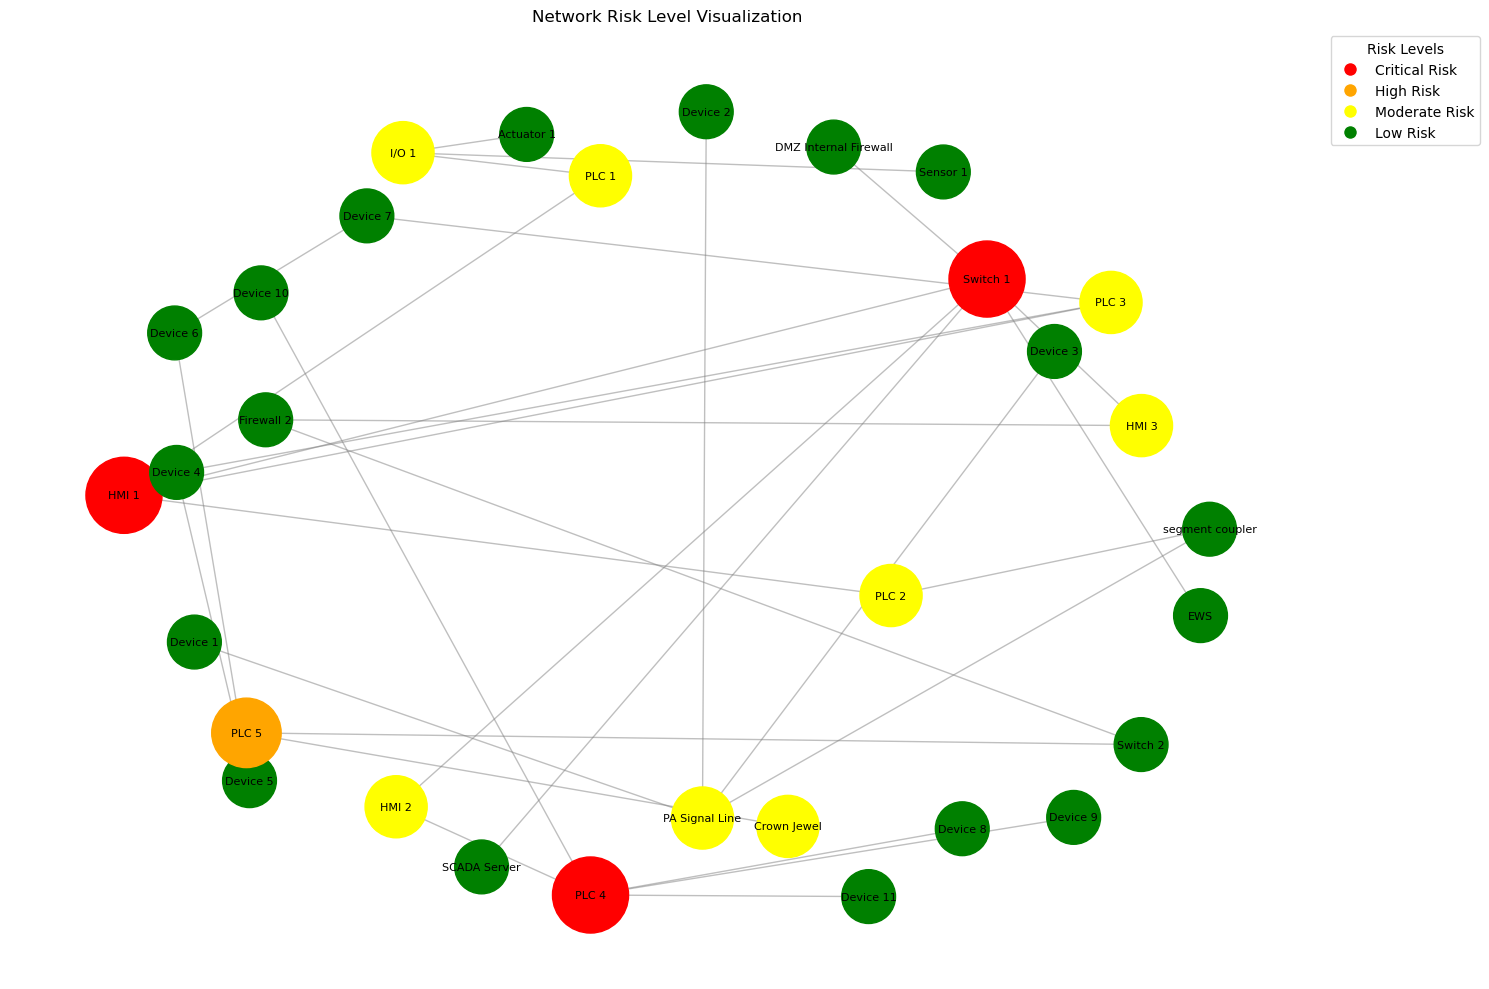

In [16]:
def calculate_security_metrics(G):
    """Calculate ICS/SCADA-specific security metrics"""
    logging.info("Starting security metrics calculation")
    metrics = {}
    
    # Define system components
    control_systems = ['PLC 1', 'PLC 2', 'PLC 3', 'PLC 4', 'PLC 5']
    hmi_systems = ['HMI 1', 'HMI 2', 'HMI 3']
    field_devices = ['Sensor 1', 'Actuator 1', 'Device 1', 'Device 2', 'Device 3', 
                    'Device 4', 'Device 5', 'Device 6', 'Device 7', 'Device 8', 
                    'Device 9', 'Device 10', 'Device 11']
    
    # Map labels to node IDs
    plc_nodes = [node for node, attr in G.nodes(data=True) if attr['label'] in control_systems]
    hmi_nodes = [node for node, attr in G.nodes(data=True) if attr['label'] in hmi_systems]
    field_nodes = [node for node, attr in G.nodes(data=True) if attr['label'] in field_devices]
    
    logging.info(f"Found {len(plc_nodes)} PLCs, {len(hmi_nodes)} HMIs, {len(field_nodes)} field devices")
    
    for node in G.nodes():
        node_label = G.nodes[node]['label']
        
        # Calculate paths with error handling
        min_path_to_plc = float('inf')
        min_path_to_hmi = float('inf')
        
        for plc in plc_nodes:
            if nx.has_path(G, node, plc):
                min_path_to_plc = min(min_path_to_plc, nx.shortest_path_length(G, node, plc))
        
        for hmi in hmi_nodes:
            if nx.has_path(G, node, hmi):
                min_path_to_hmi = min(min_path_to_hmi, nx.shortest_path_length(G, node, hmi))
        
        # Store metrics
        metrics[node] = {
            'plc_connections': sum(1 for n in G.neighbors(node) if n in plc_nodes),
            'hmi_connections': sum(1 for n in G.neighbors(node) if n in hmi_nodes),
            'field_connections': sum(1 for n in G.neighbors(node) if n in field_nodes),
            'min_path_to_plc': min_path_to_plc,
            'min_path_to_hmi': min_path_to_hmi,
            'is_control_system': int(node_label in control_systems),
            'is_hmi': int(node_label in hmi_systems),
            'is_field_device': int(node_label in field_devices)
        }
        
        logging.info(f"Calculated metrics for node {node_label}")
    
    return metrics

def enhance_security_anomaly_detection(G, security_metrics):
    """Enhanced anomaly detection with ICS-specific features"""
    features = pd.DataFrame()
    
    # Add centrality measures
    features['degree_cent'] = pd.Series(centrality_measures['Degree_Centrality'])
    features['betweenness_cent'] = pd.Series(centrality_measures['Betweenness_Centrality'])
    features['closeness_cent'] = pd.Series(centrality_measures['Closeness_Centrality'])
    
    # Add security metrics
    for node in G.nodes():
        for metric, value in security_metrics[node].items():
            if metric not in features:
                features[metric] = 0
            # Replace infinite values with a large number
            if value == float('inf'):
                features.loc[node, metric] = 1000  # Using a large finite number
            else:
                features.loc[node, metric] = float(value)
    
    # Calculate exposure score safely
    features['plc_path_factor'] = features['min_path_to_plc'].apply(
        lambda x: 1/(x+1) if x < 1000 else 0)
    features['hmi_path_factor'] = features['min_path_to_hmi'].apply(
        lambda x: 1/(x+1) if x < 1000 else 0)
    
    # Weighted exposure score
    features['exposure_score'] = (
        features['plc_connections'] * 3 +
        features['hmi_connections'] * 2 +
        features['field_connections'] +
        features['plc_path_factor'] * 2 +
        features['hmi_path_factor'] * 1.5
    )
    
    # Select and prepare features for scaling
    scaling_features = [
        'degree_cent', 'betweenness_cent', 'closeness_cent',
        'plc_connections', 'hmi_connections', 'field_connections',
        'plc_path_factor', 'hmi_path_factor', 'exposure_score',
        'is_control_system', 'is_hmi', 'is_field_device'
    ]
    
    features_for_scaling = features[scaling_features].copy()
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = pd.DataFrame(
        scaler.fit_transform(features_for_scaling),
        columns=scaling_features,
        index=features.index
    )
    
    # Run Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
    features['anomaly'] = iso_forest.fit_predict(features_scaled)
    features['anomaly_score'] = iso_forest.score_samples(features_scaled)
    
    # Convert to risk score (0-100)
    min_score = features['anomaly_score'].min()
    max_score = features['anomaly_score'].max()
    features['risk_score'] = 100 * (features['anomaly_score'] - max_score) / (min_score - max_score)
    
    return features

def visualize_risk_levels(G, risk_scores):
    """Create visualizations of network risk levels"""
    plt.figure(figsize=(15, 10))
    
    # Create custom layout
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Create node colors based on risk scores
    risk_colors = []
    node_sizes = []
    for node in G.nodes():
        risk_score = risk_scores.loc[node, 'risk_score']
        
        # Color mapping
        if risk_score >= 75:
            color = 'red'
            size = 3000
        elif risk_score >= 50:
            color = 'orange'
            size = 2500
        elif risk_score >= 25:
            color = 'yellow'
            size = 2000
        else:
            color = 'green'
            size = 1500
            
        risk_colors.append(color)
        node_sizes.append(size)
    
    # Draw the network
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
    nodes = nx.draw_networkx_nodes(G, pos, 
                                 node_color=risk_colors,
                                 node_size=node_sizes)
    
    # Add labels
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                label=f'{level} Risk',
                                markerfacecolor=color, markersize=10)
                      for level, color in [('Critical', 'red'), 
                                         ('High', 'orange'),
                                         ('Moderate', 'yellow'),
                                         ('Low', 'green')]]
    
    plt.legend(handles=legend_elements, loc='upper left', 
              title='Risk Levels', bbox_to_anchor=(1, 1))
    
    plt.title('Network Risk Level Visualization')
    plt.axis('off')
    plt.tight_layout()
    
    # Save visualization
    plt.savefig(os.path.join(output_path, 'risk_level_visualization.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()

# Run enhanced security analysis
print("\nEnhanced Security Analysis:")
security_metrics = calculate_security_metrics(G)
security_features = enhance_security_anomaly_detection(G, security_metrics)

# Display results
print("\nDetailed Security Analysis Results:")
print("--------------------------------")
for node in G.nodes():
    node_label = G.nodes[node]['label']
    risk_score = security_features.loc[node, 'risk_score']
    metrics = security_metrics[node]
    
    # Only show detailed analysis for nodes with risk score > 25
    if risk_score > 25:
        print(f"\nNode: {node_label}")
        print(f"Risk Score: {risk_score:.1f}/100")
        print("Security Metrics:")
        print(f"  Control System Connections:")
        print(f"    - PLC Connections: {metrics['plc_connections']}")
        print(f"    - HMI Connections: {metrics['hmi_connections']}")
        print(f"    - Field Device Connections: {metrics['field_connections']}")
        print(f"  Access Paths:")
        print(f"    - Shortest Path to PLC: {metrics['min_path_to_plc']}")
        print(f"    - Shortest Path to HMI: {metrics['min_path_to_hmi']}")
        print(f"  Exposure Score: {security_features.loc[node, 'exposure_score']:.2f}")

# Create and save visualization
visualize_risk_levels(G, security_features)

# Save detailed results
with open(os.path.join(output_path, 'detailed_security_analysis.txt'), 'w') as f:
    f.write("Detailed Security Analysis Report\n")
    f.write("===============================\n\n")
    
    for node in G.nodes():
        node_label = G.nodes[node]['label']
        risk_score = security_features.loc[node, 'risk_score']
        metrics = security_metrics[node]
        
        f.write(f"\nNode: {node_label}\n")
        f.write(f"Risk Score: {risk_score:.1f}/100\n")
        f.write("Security Metrics:\n")
        for metric, value in metrics.items():
            f.write(f"  {metric}: {value}\n")
        f.write(f"Exposure Score: {security_features.loc[node, 'exposure_score']:.2f}\n")